In [267]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tools import categorical
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score,classification_report, confusion_matrix
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


import datetime
import matplotlib.cm as cm
%matplotlib inline
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.stats import skew, boxcox



plt.style.use('ggplot')

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

<module 'seaborn' from '/usr/local/lib/python3.6/dist-packages/seaborn/__init__.py'>

In [47]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().values.any()

False

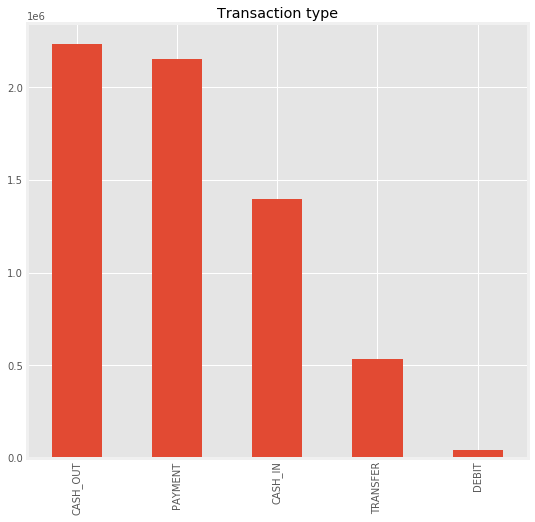

In [65]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

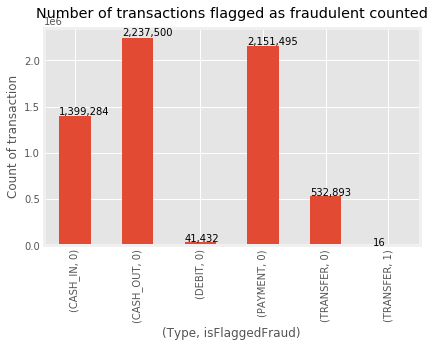

In [66]:
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("Number of transactions flagged as fraudulent counted",pad=10)
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

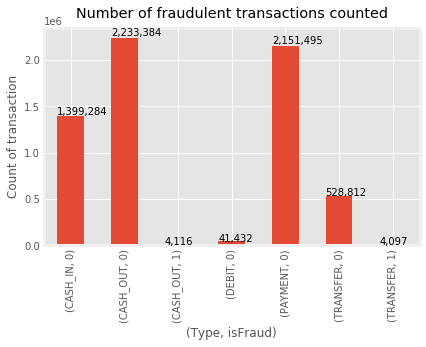

In [67]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("Number of fraudulent transactions counted",pad=10)
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

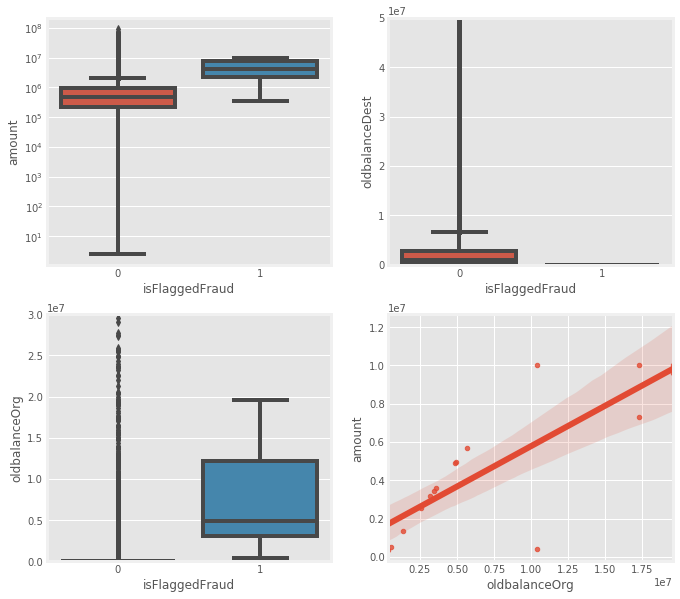

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = df.loc[(df.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()


In [143]:
tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

print(tmp.head(3))

       type     amount  oldbalanceOrg  ...  newbalanceDest  isFraud  type_num
0  TRANSFER     181.00          181.0  ...            0.00        1         1
1  CASH_OUT     181.00          181.0  ...            0.00        1         0
2  CASH_OUT  229133.94        15325.0  ...        51513.44        0         0

[3 rows x 8 columns]


<AxesSubplot:>

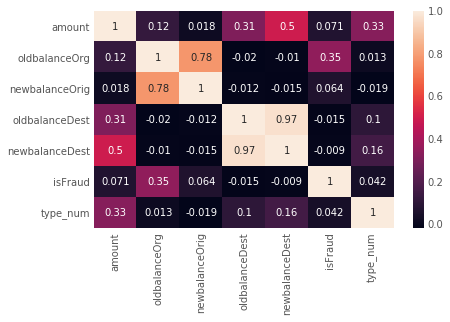

In [156]:
sns.heatmap(tmp.corr(),annot=True)

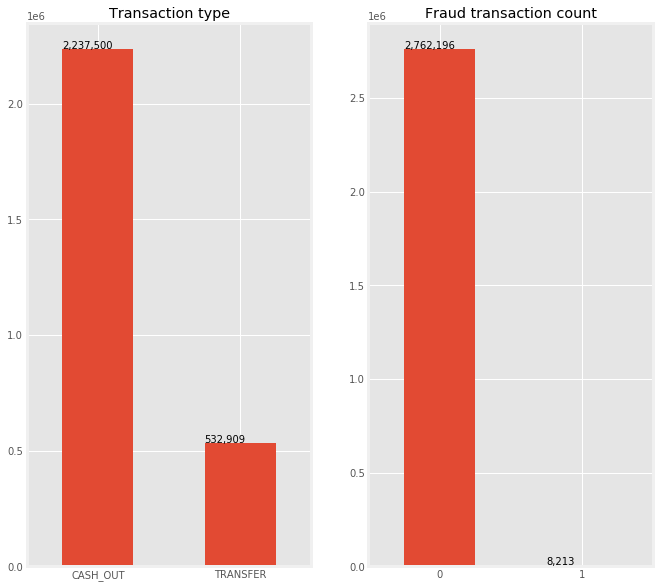

In [157]:
df1 = tmp.type.value_counts()
df2 = pd.value_counts(tmp['isFraud'], sort = True).sort_index()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))

df1.plot(ax=ax1, kind='bar',title="Transaction type")
for p in ax1.patches:
  ax1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

for tick in ax1.get_xticklabels():
  tick.set_rotation(0)


df2.plot(ax=ax2, kind='bar',title="Fraud transaction count")
for p in ax2.patches:
  ax2.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
for tick in ax2.get_xticklabels():
  tick.set_rotation(0)





In [211]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y = X['isFraud']

In [212]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud','isFraud'], axis = 1)

In [213]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

In [261]:
sc = StandardScaler()
sc.fit(X)
sc_X = sc.transform(X)

In [262]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

print('Original dataset shape %s' % Counter(Y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 2762196, 1: 8213})
Resampled dataset shape Counter({1: 2762196, 0: 2762196})


In [281]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.7, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_res, y_res, test_size=0.7, random_state=0)


In [282]:
feature_names

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [286]:
dtrain = xgb.DMatrix(X_train,y_train,feature_names= ['step', 'type', 'amount', 'oldbalanceOrg', 
                                                     'newbalanceOrig','oldbalanceDest', 'newbalanceDest'])
dvalid = xgb.DMatrix(X_valid,y_valid,feature_names= ['step', 'type', 'amount', 'oldbalanceOrg', 
                                                     'newbalanceOrig','oldbalanceDest', 'newbalanceDest'])
dtest = xgb.DMatrix(X_test,y_test,feature_names= ['step', 'type', 'amount', 'oldbalanceOrg', 
                                                     'newbalanceOrig','oldbalanceDest', 'newbalanceDest'])

watchlist = [(dtrain, 'train'),(dvalid,'valid')]
MAX_ROUNDS = 300
EARLY_STOP = 50
VERBOSE_EVAL = 50

params = {'objective':'binary:logistic',
          'eta' : 0.039,
          'silent' : True,
          'max_depth':2,
          'subsample':0.8,
          'colsample_bytee':0.9,
          'eval_metric':'auc',
          'random_state':0.2}

In [287]:
model = xgb.train(params,
                  dtrain,
                  MAX_ROUNDS,
                  watchlist,
                  early_stopping_rounds=EARLY_STOP,
                  maximize=True,
                  verbose_eval = VERBOSE_EVAL)

[0]	train-auc:0.921228	valid-auc:0.92145
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.986516	valid-auc:0.986622
[100]	train-auc:0.992253	valid-auc:0.992334
[150]	train-auc:0.995032	valid-auc:0.995086
[200]	train-auc:0.996297	valid-auc:0.996334
[250]	train-auc:0.996916	valid-auc:0.996949
[299]	train-auc:0.99737	valid-auc:0.997394


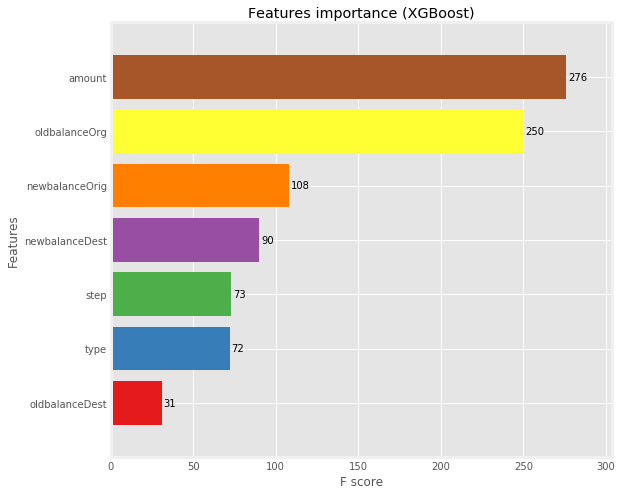

In [289]:
fig,(ax) = plt.subplots(ncols=1,figsize=(8,8))

colours = plt.cm.Set1(np.linspace(0, 1, 9))

xgb.plot_importance(model,height=0.8,title="Features importance (XGBoost)", ax=ax,color=colours)
plt.show()

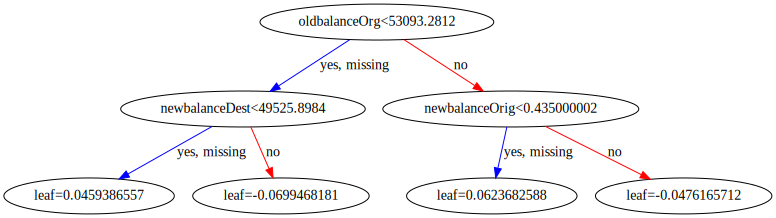

In [290]:
to_graphviz(model)